Dikarena jumlah dataset sangat besar maka saya melakukan dataset familiarization menggunakan 500.000 sample data agar python notebook bisa menjalankannya

# Import Library

In [ ]:
!pip install google-cloud-bigquery-storage

In [ ]:
!pip install google-cloud-bigquery

In [ ]:
!pip install db-dtypes

In [ ]:
!pip install mne scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from scipy.signal import butter, filtfilt, iirnotch



# BigQuery
from google.cloud import bigquery
from google.cloud import bigquery_storage

warnings.filterwarnings('ignore')

In [ ]:
# Set environment variable untuk kredensial (gunakan file kunci layanan)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/codespaces-blank/client_secrets.json"

# Inisialisasi BigQuery client
project_id = 'ocr-ktp-417704'
client = bigquery.Client(project=project_id)

# Dataset Familiarization

## Load data local

In [ ]:
# Query untuk mengambil data dari tabel di dataset NeuralData
query = """
    SELECT *
    FROM `ocr-ktp-417704.Local.localdata`
"""

# Jalankan query
query_job = client.query(query)

# Simpan hasil ke pandas DataFrame
local = query_job.to_dataframe()

In [ ]:
local

,ID del participante,Trial,Respuesta,Tiempo de inicio,Tiempo de aparición de letras,Tiempo de la pulsación,Tecla elegida,Tiempo de aparición de la letra observada,Letra observada
0,16,0,4,2023-05-09 20:28:11.882000+00:00,2023-05-09 20:28:13.890000+00:00,2023-05-09 20:28:19.921000+00:00,p,2023-05-09 20:28:18.171000+00:00,#
1,16,0,5,2023-05-09 20:28:20.978000+00:00,2023-05-09 20:28:22.987000+00:00,2023-05-09 20:28:27.446000+00:00,p,2023-05-09 20:28:25.696000+00:00,#
2,16,0,9,2023-05-09 20:28:55.608000+00:00,2023-05-09 20:28:57.611000+00:00,2023-05-09 20:29:04.332000+00:00,p,2023-05-09 20:29:02.582000+00:00,#
3,16,1,7,2023-05-09 20:32:08.989000+00:00,2023-05-09 20:32:10.995000+00:00,2023-05-09 20:32:18.506000+00:00,p,2023-05-09 20:32:16.756000+00:00,#
4,16,1,11,2023-05-09 20:32:53.355000+00:00,2023-05-09 20:32:55.363000+00:00,2023-05-09 20:32:58.464000+00:00,p,2023-05-09 20:32:56.714000+00:00,#
...,...,...,...,...,...,...,...,...,...
2574,0,1,5,2023-05-01 18:04:58.200000+00:00,2023-05-01 18:05:00.290000+00:00,2023-05-01 18:05:05.799000+00:00,q,2023-05-01 18:05:05.525000+00:00,t
2575,0,3,2,2023-05-01 18:12:32.807000+00:00,2023-05-01 18:12:34.813000+00:00,2023-05-01 18:12:43.560000+00:00,q,2023-05-01 18:12:43.309000+00:00,t
2576,0,5,14,2023-05-01 18:22:17.986000+00:00,2023-05-01 18:22:19.989000+00:00,2023-05-01 18:22:23.697000+00:00,q,2023-05-01 18:22:23.493000+00:00,t
2577,0,6,13,2023-05-01 18:26:55.649000+00:00,2023-05-01 18:26:57.653000+00:00,2023-05-01 18:27:03.471000+00:00,q,2023-05-01 18:27:03.157000+00:00,t


### Exploare local dataset

In [ ]:
# Ganti nama kolom

local.rename(columns={
    'ID del participante': 'ID',
    'Trial': 'Trial',
    'Respuesta': 'Response',
    'Tiempo de inicio': 'Start_Time',
    'Tiempo de aparición de letras': 'Letter_Appearance_Time',
    'Tiempo de la pulsación': 'Key_Press_Time',
    'Tecla elegida': 'Chosen_Key',
    'Tiempo de aparición de la letra observada': 'Observed_Letter_Appearance_Time',
    'Letra observada': 'Observed_Letter'
}, inplace=True)

In [ ]:
# Menghitung waktu reaksi: selisih antara "letter appearance time" dan "time of the keystroke"

local['Reaction_Time'] = local['Key_Press_Time'] - local['Letter_Appearance_Time']

In [ ]:
local

,ID,Trial,Response,Start_Time,Letter_Appearance_Time,Key_Press_Time,Chosen_Key,Observed_Letter_Appearance_Time,Observed_Letter,Reaction_Time
0,16,0,4,2023-05-09 20:28:11.882000+00:00,2023-05-09 20:28:13.890000+00:00,2023-05-09 20:28:19.921000+00:00,p,2023-05-09 20:28:18.171000+00:00,#,0 days 00:00:06.031000
1,16,0,5,2023-05-09 20:28:20.978000+00:00,2023-05-09 20:28:22.987000+00:00,2023-05-09 20:28:27.446000+00:00,p,2023-05-09 20:28:25.696000+00:00,#,0 days 00:00:04.459000
2,16,0,9,2023-05-09 20:28:55.608000+00:00,2023-05-09 20:28:57.611000+00:00,2023-05-09 20:29:04.332000+00:00,p,2023-05-09 20:29:02.582000+00:00,#,0 days 00:00:06.721000
3,16,1,7,2023-05-09 20:32:08.989000+00:00,2023-05-09 20:32:10.995000+00:00,2023-05-09 20:32:18.506000+00:00,p,2023-05-09 20:32:16.756000+00:00,#,0 days 00:00:07.511000
4,16,1,11,2023-05-09 20:32:53.355000+00:00,2023-05-09 20:32:55.363000+00:00,2023-05-09 20:32:58.464000+00:00,p,2023-05-09 20:32:56.714000+00:00,#,0 days 00:00:03.101000
...,...,...,...,...,...,...,...,...,...,...
2574,0,1,5,2023-05-01 18:04:58.200000+00:00,2023-05-01 18:05:00.290000+00:00,2023-05-01 18:05:05.799000+00:00,q,2023-05-01 18:05:05.525000+00:00,t,0 days 00:00:05.509000
2575,0,3,2,2023-05-01 18:12:32.807000+00:00,2023-05-01 18:12:34.813000+00:00,2023-05-01 18:12:43.560000+00:00,q,2023-05-01 18:12:43.309000+00:00,t,0 days 00:00:08.747000
2576,0,5,14,2023-05-01 18:22:17.986000+00:00,2023-05-01 18:22:19.989000+00:00,2023-05-01 18:22:23.697000+00:00,q,2023-05-01 18:22:23.493000+00:00,t,0 days 00:00:03.708000
2577,0,6,13,2023-05-01 18:26:55.649000+00:00,2023-05-01 18:26:57.653000+00:00,2023-05-01 18:27:03.471000+00:00,q,2023-05-01 18:27:03.157000+00:00,t,0 days 00:00:05.818000


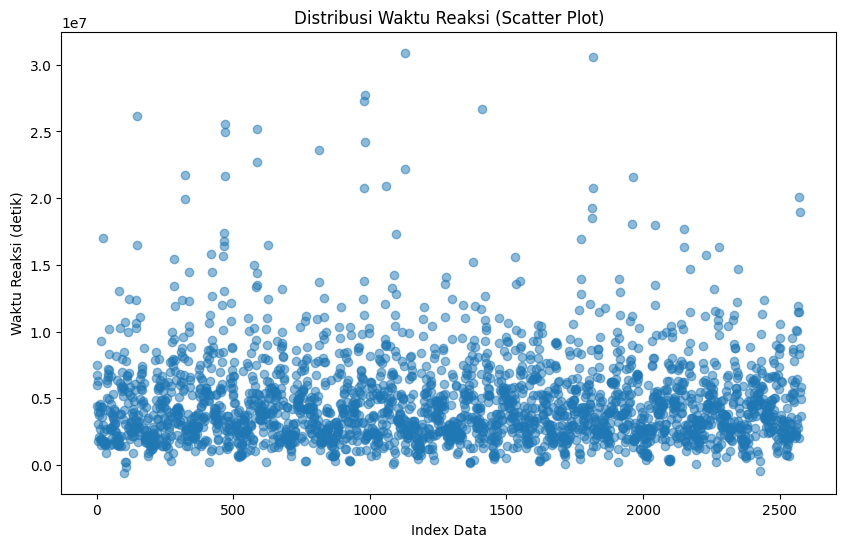

In [ ]:
# show distribution time

plt.figure(figsize=(10, 6))
plt.scatter(local.index, local['Reaction_Time'], alpha=0.5)
plt.title('Distribusi Waktu Reaksi (Scatter Plot)')
plt.xlabel('Index Data')
plt.ylabel('Waktu Reaksi (detik)')
plt.show()


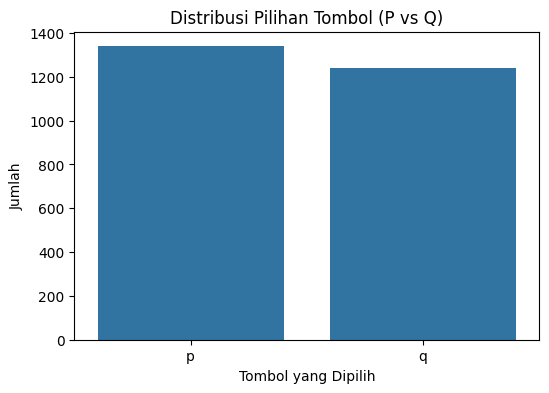

In [ ]:
# 3. Analisis distribusi pilihan tombol

plt.figure(figsize=(6, 4))
sns.countplot(x='Chosen_Key', data=local)
plt.title('Distribusi Pilihan Tombol (P vs Q)')
plt.xlabel('Tombol yang Dipilih')
plt.ylabel('Jumlah')
plt.show()

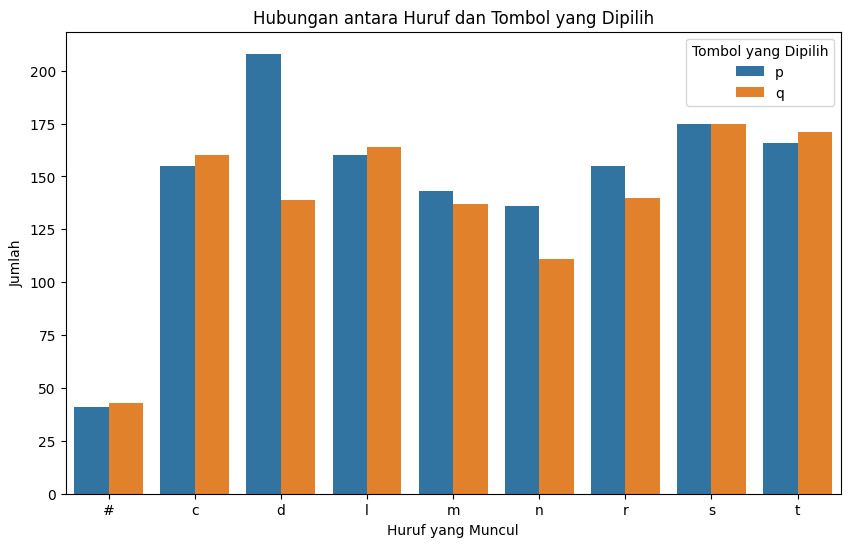

In [ ]:
# 4. Analisis hubungan antara huruf yang muncul dan tombol yang dipilih

plt.figure(figsize=(10, 6))
sns.countplot(x='Observed_Letter', hue='Chosen_Key', data=local)
plt.title('Hubungan antara Huruf dan Tombol yang Dipilih')
plt.xlabel('Huruf yang Muncul')
plt.ylabel('Jumlah')
plt.legend(title='Tombol yang Dipilih', loc='upper right')
plt.show()

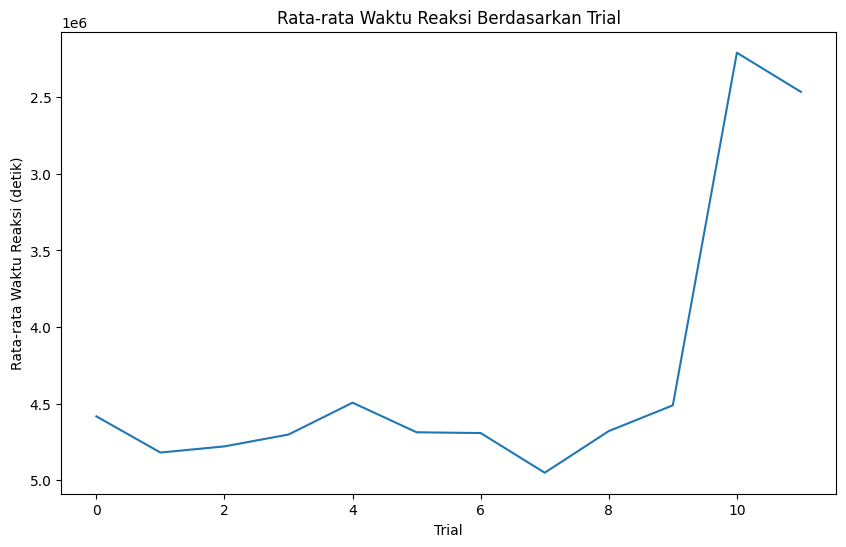

In [ ]:
# 5. Menghitung perubahan waktu reaksi berdasarkan trial
avg_reaction_by_trial = local.groupby('Trial')['Reaction_Time'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_reaction_by_trial.index, y=avg_reaction_by_trial.values)
plt.title('Rata-rata Waktu Reaksi Berdasarkan Trial')
plt.xlabel('Trial')
plt.ylabel('Rata-rata Waktu Reaksi (detik)')
plt.show()

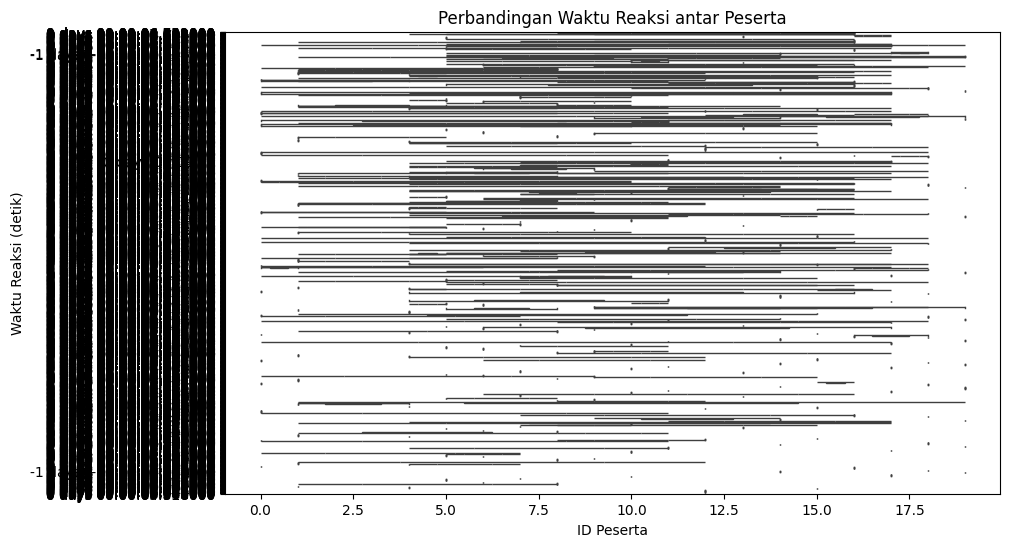

In [ ]:
# 6. Membandingkan waktu reaksi antar peserta

plt.figure(figsize=(10, 6))
sns.boxplot(x='ID', y='Reaction_Time', data=local)
plt.title('Perbandingan Waktu Reaksi antar Peserta')
plt.xlabel('ID Peserta')
plt.ylabel('Waktu Reaksi (detik)')
plt.show()

In [ ]:
# 7. Menganalisis apakah huruf yang diingat sesuai dengan huruf yang muncul
local['correct_recall'] = local['Observed_Letter'] == local['Letter_Appearance_Time']

# Presentase akurasi recall
accuracy = local['correct_recall'].mean() * 100
print(f'Akurasi recall huruf: {accuracy:.2f}%')

Akurasi recall huruf: 0.00%


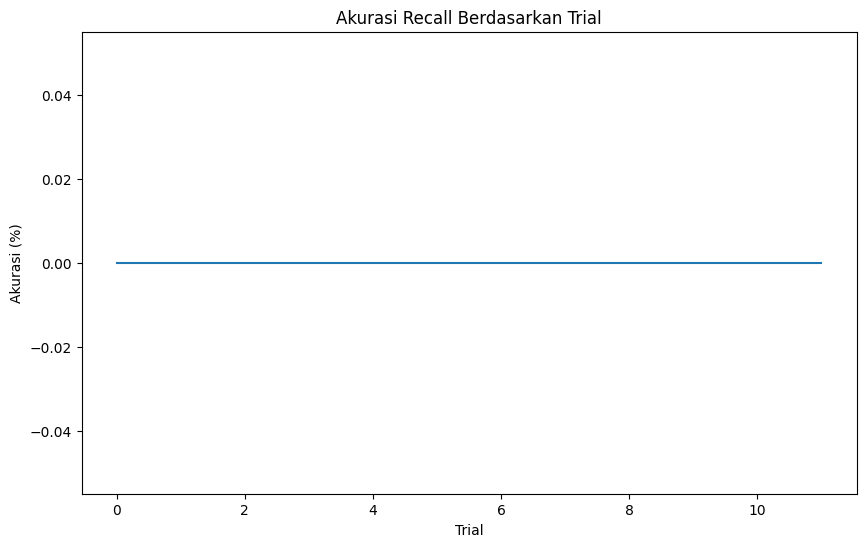

In [ ]:
# 9. Perbandingan akurasi recall berdasarkan trial
accuracy_by_trial = local.groupby('Trial')['correct_recall'].mean() * 100

plt.figure(figsize=(10, 6))
sns.lineplot(x=accuracy_by_trial.index, y=accuracy_by_trial.values)
plt.title('Akurasi Recall Berdasarkan Trial')
plt.xlabel('Trial')
plt.ylabel('Akurasi (%)')
plt.show()

In [ ]:
# Tampilkan nama-nama kolom dari dataset EEG

local.columns

Index(['ID', 'Trial', 'Response', 'Start_Time', 'Letter_Appearance_Time',
       'Key_Press_Time', 'Chosen_Key', 'Observed_Letter_Appearance_Time',
       'Observed_Letter', 'Reaction_Time', 'correct_recall'],
      dtype='object')

## Load eeg data

In [ ]:
# Set up BigQuery Client
client = bigquery.Client()

# Set up BigQuery Storage Client
bqstorage_client = bigquery_storage.BigQueryReadClient()

# Query BigQuery
query = """
    SELECT *
    FROM `ocr-ktp-417704.museeeg.EEG`
    LIMIT 500000
"""
query_job = client.query(query)

# Fetch the results and store them in a Pandas DataFrame
eeg = query_job.to_dataframe(bqstorage_client=bqstorage_client)

In [ ]:
eeg

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2023-05-03 19:41:33.382000+00:00,0.626673,0.000000,0.531954,0.149477,0.670385,0.000000,0.048211,0.420813,0.909295,...,5.211334,-0.620575,0.448608,1,1.0,1.0,1.0,1.0,90.0,None
1,2023-05-03 19:41:41.048000+00:00,0.542175,0.000000,1.097218,1.027884,0.722108,0.000000,0.590014,0.361350,0.908308,...,8.538513,-42.124329,6.960907,1,2.0,1.0,1.0,1.0,95.0,None
2,2023-05-03 19:41:41.984000+00:00,0.542175,0.000000,1.097218,1.027884,0.722108,0.000000,0.590014,0.361350,0.908308,...,12.299347,6.153412,6.691742,1,2.0,2.0,1.0,2.0,95.0,None
3,2023-05-03 19:41:47.161000+00:00,-0.178963,-0.124027,0.111401,0.566585,0.451829,0.069640,-0.217366,0.417588,0.725102,...,5.749664,-0.134583,4.456177,1,1.0,1.0,1.0,1.0,90.0,None
4,2023-05-03 19:41:48.171000+00:00,-0.044511,-0.071640,0.238139,0.388679,0.620384,0.085722,-0.030771,0.376634,0.763963,...,5.450592,-0.530853,4.717865,1,1.0,1.0,1.0,1.0,90.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2023-04-23 12:53:24.237000+00:00,4.091359,0.371186,0.625800,-3.504138,3.149646,0.128965,0.081840,-3.378557,3.368837,...,7.514191,-4.231873,7.843170,1,2.0,1.0,1.0,2.0,100.0,None
499996,2023-04-23 12:53:26.096000+00:00,4.091359,0.054532,0.646295,-3.504138,3.149646,0.104014,-0.212151,-3.378557,3.368837,...,5.473022,0.209351,4.209442,1,4.0,1.0,1.0,4.0,100.0,None
499997,2023-04-23 12:53:31.665000+00:00,4.091359,0.299317,0.212461,-3.504138,3.149646,0.081819,-0.137181,-3.378557,3.368837,...,5.772095,-0.216827,4.882355,1,4.0,1.0,1.0,4.0,100.0,None
499998,2023-04-23 12:53:36.533000+00:00,4.091359,0.092658,0.433713,-3.504138,3.149646,-0.166111,0.142715,-3.378557,3.368837,...,5.906677,-0.844879,4.142151,1,4.0,1.0,1.0,4.0,100.0,None


In [ ]:
local_data = local.copy()
eeg_data = eeg.copy()

### Explore Eeg Data

<Figure size 1000x600 with 0 Axes>

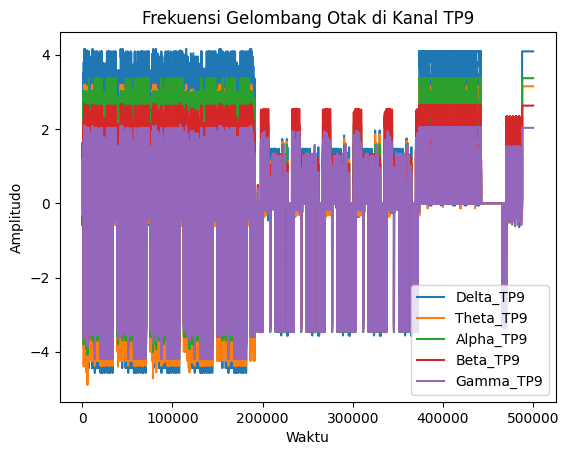

In [ ]:
# Freq distribution brain wave

plt.figure(figsize=(10, 6))
eeg_data[['Delta_TP9', 'Theta_TP9', 'Alpha_TP9', 'Beta_TP9', 'Gamma_TP9']].plot()
plt.title('Frekuensi Gelombang Otak di Kanal TP9')
plt.ylabel('Amplitudo')
plt.xlabel('Waktu')
plt.show()

In [ ]:
eeg_corr = eeg.copy()

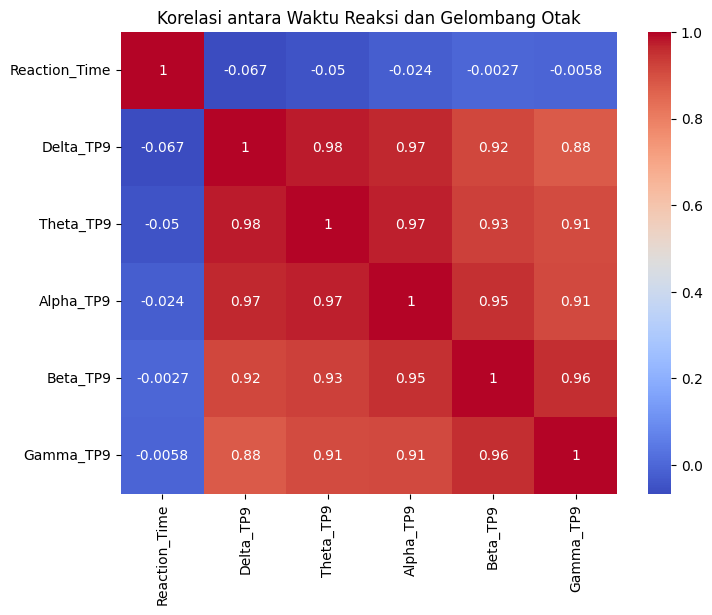

In [ ]:
# Konversi kolom waktu ke format datetime jika belum dilakukan
eeg_corr['TimeStamp'] = pd.to_datetime(eeg_corr['TimeStamp'])
local_data['Start_Time'] = pd.to_datetime(local_data['Start_Time'])

# Urutkan DataFrame berdasarkan kolom waktu
eeg_corr = eeg_corr.sort_values('TimeStamp')
local_data = local_data.sort_values('Start_Time')

# Gabungkan dataset EEG dengan local berdasarkan waktu terdekat
combined_df = pd.merge_asof(eeg_corr, local_data[['Start_Time', 'Reaction_Time']], left_on='TimeStamp', right_on='Start_Time', direction='nearest')

# Hitung korelasi antara waktu reaksi dan gelombang otak
corr = combined_df[['Reaction_Time', 'Delta_TP9', 'Theta_TP9', 'Alpha_TP9', 'Beta_TP9', 'Gamma_TP9']].corr()

# Plot heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi antara Waktu Reaksi dan Gelombang Otak')
plt.show()


<Figure size 1000x600 with 0 Axes>

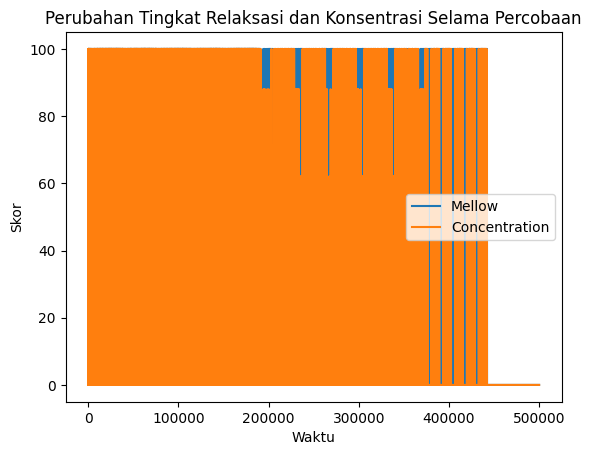

In [ ]:
# mellow and concentration

plt.figure(figsize=(10, 6))
eeg_data[['Mellow', 'Concentration']].plot()
plt.title('Perubahan Tingkat Relaksasi dan Konsentrasi Selama Percobaan')
plt.ylabel('Skor')
plt.xlabel('Waktu')
plt.show()

<Figure size 1000x600 with 0 Axes>

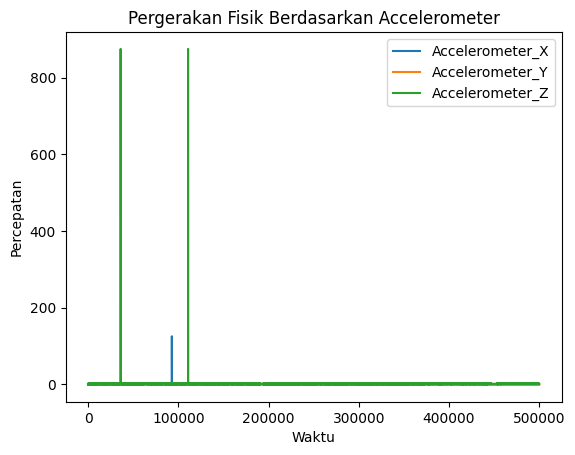

In [ ]:
# Physical move detection

plt.figure(figsize=(10, 6))
eeg_data[['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']].plot()
plt.title('Pergerakan Fisik Berdasarkan Accelerometer')
plt.ylabel('Percepatan')
plt.xlabel('Waktu')
plt.show()

In [ ]:
# External Elements

unique_elements = eeg_data['Elements'].unique()
print("Aktivitas yang terdeteksi:", unique_elements)

Aktivitas yang terdeteksi: [None '/muse/elements/blink' '/muse/elements/jaw_clench']


In [ ]:
# Cek adanya nilai yang hilang di dataset EEG

eeg.isnull().sum()

TimeStamp               0
Delta_TP9            2531
Delta_AF7            2531
Delta_AF8            2531
Delta_TP10           2531
Theta_TP9            2531
Theta_AF7            2531
Theta_AF8            2531
Theta_TP10           2531
Alpha_TP9            2531
Alpha_AF7            2531
Alpha_AF8            2531
Alpha_TP10           2531
Beta_TP9             2531
Beta_AF7             2531
Beta_AF8             2531
Beta_TP10            2531
Gamma_TP9            2531
Gamma_AF7            2531
Gamma_AF8            2531
Gamma_TP10           2531
RAW_TP9             10042
RAW_AF7              9989
RAW_AF8             10071
RAW_TP10            10002
AUX_RIGHT           10016
Mellow               2531
Concentration        2531
Accelerometer_X      2531
Accelerometer_Y      2531
Accelerometer_Z      2531
Gyro_X               2531
Gyro_Y               2531
Gyro_Z               2531
HeadBandOn           2531
HSI_TP9              2531
HSI_AF7              2531
HSI_AF8              2531
HSI_TP10    